In [1]:
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import tensorflow as tf
import random
from torchsummary import summary
import shap
from torch.optim.lr_scheduler import StepLR

In [2]:
torch.manual_seed(5)
random.seed(5)

In [3]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [1/0.229, 1/0.224, 1/0.225]),
                                transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                                     std = [ 1., 1., 1. ]),
                               ])


In [4]:
batch_size = 4
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=(0.9,1.1), contrast=(1,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'mri'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}

class_names = image_datasets['Training'].classes


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



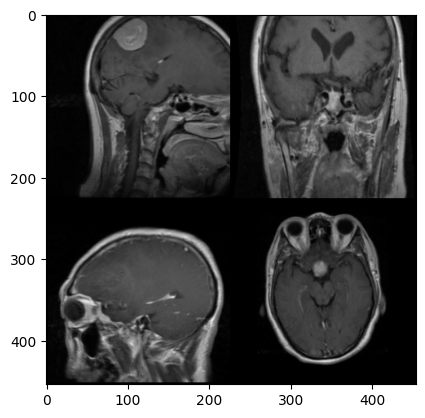

In [5]:
batch_tensor = next(iter(dataloaders["Training"]))
batch_tensor = invTrans(batch_tensor[0])
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=2)
plt.imshow(grid_img.permute(1, 2, 0))

In [6]:
criterion = nn.CrossEntropyLoss()
model = torch.hub.load('pytorch/vision:v0.16.0', 'efficientnet_v2_s', weights="IMAGENET1K_V1")
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


Using cache found in C:\Users\emiel/.cache\torch\hub\pytorch_vision_v0.16.0


In [7]:
model = nn.Sequential(
    model,
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000,4)
)

In [8]:
model = model.to(device)

In [9]:
def validate():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloaders['Testing']:
            inputs, labels = data
            
            inputs = inputs.to(torch.device('cuda'))
            labels = labels.to(torch.device('cuda'))
            
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return loss.item(), 100 * correct / total

In [10]:
epochs = 50
best_test_acc = 0
for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    print()
    pbar = tf.keras.utils.Progbar(target=len(dataloaders['Training']))
    
    correct = 0
    total = 0
    
    for i, data in enumerate(dataloaders['Training'], 0):
        
        inputs, labels = data
        
        inputs = inputs.to(torch.device('cuda'))
        labels = labels.to(torch.device('cuda'))

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.update(i, values=[("loss",loss.item())])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    test_loss, test_accuracy = validate()
    train_accuracy = 100 * correct / total
    pbar.update(i, values=[("train_accuracy", train_accuracy), ("test_accuracy", test_accuracy), ("test_loss",test_loss)])
    running_loss = 0.0

    if test_accuracy > best_test_acc:
        if os.path.exists(f"efficientnet_v2_s_{round(best_test_acc,2)}"):
            os.remove(f"efficientnet_v2_s_{round(best_test_acc,2)}")
        best_test_acc = test_accuracy
        torch.save(model.state_dict(), f"efficientnet_v2_s_{round(test_accuracy,2)}")
        
    scheduler.step()


print('Finished Training')


717/718 [============================>.] - ETA: 0s - loss: 0.2341 - train_accuracy: 91.5331 - test_accuracy: 78.8945 - test_loss: 0.1076Finished Training


In [11]:
predictions = []
alllabels = []
with torch.no_grad():
        for data in dataloaders['Testing']:
            inputs, labels = data
            
            inputs = inputs.to(torch.device('cuda'))
            labels = labels.to(torch.device('cuda'))
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            predictions.append(predicted.cpu().data.numpy())
            alllabels.append(labels.cpu().data.numpy())

In [12]:
def random_classification():
    with torch.no_grad():
        index = random.randint(0, batch_size - 1)
        dataiter = iter(dataloaders['Testing'])
        input, labels = next(dataiter)

        predictions = model(input)
        label = class_names[labels[index].item()]

        predicted_label = class_names[predictions[index].argmax().item()]

        img = input[index].permute(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())

        plt.imshow(img)
        plt.title(f"Real: {label} \nPrediction: {predicted_label}\n", color='green' if label == predicted_label else 'red')
        plt.show()

In [13]:
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [14]:
model = model.to("cpu")

In [15]:
targets, classes = next(iter(dataloaders['Testing']))

In [16]:
classes

tensor([1, 2, 0, 3])

In [17]:
sample = targets[:4]

In [18]:
e = shap.GradientExplainer((model, model[-4].features[-1]), next(iter(dataloaders['Testing']))[0], local_smoothing = 0.1)
shap_values, indexes = e.shap_values(sample, ranked_outputs=1, nsamples=100
)

In [19]:
index_names = np.array(class_names)[indexes]


In [20]:

sample = invTrans(sample)
sample = np.swapaxes(np.swapaxes(np.array(sample),1,3),1,2)

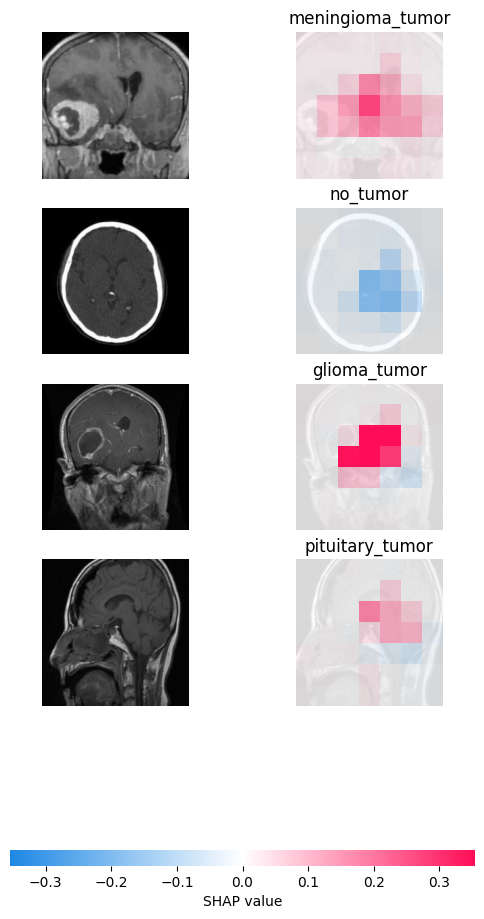

In [21]:
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, sample, index_names)

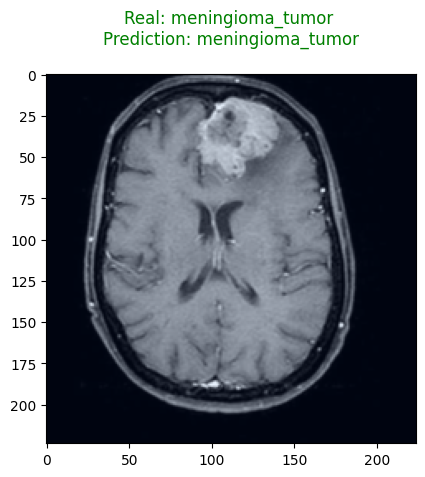

In [22]:
random_classification()